<a href="https://colab.research.google.com/github/sznajder/Lectures/blob/master/HowNNLearn_MiniNNExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning from Small Neural Networks , by Dan Hipschman

"Here’s an important concept. The outputs of the final hidden layer are (ideally) linearly separable. The output layer is simply a linear function, so if the neural network is working perfectly (i.e., classifying with 100% accuracy), then the inputs to the output layer are linearly separable. (It’s true that often the output layer has a non-linearity such as a sigmoid or softmax, but this simply scales the output, it doesn’t add classifying power. It’s there to make the error easier to minimize.)
So said differently, all the hidden layers do is transform the input so that it’s linearly separable to the final output layer. Training a neural network is basically finding a transformation, like the distance-from-zero one, just a much more messy and complicated one."

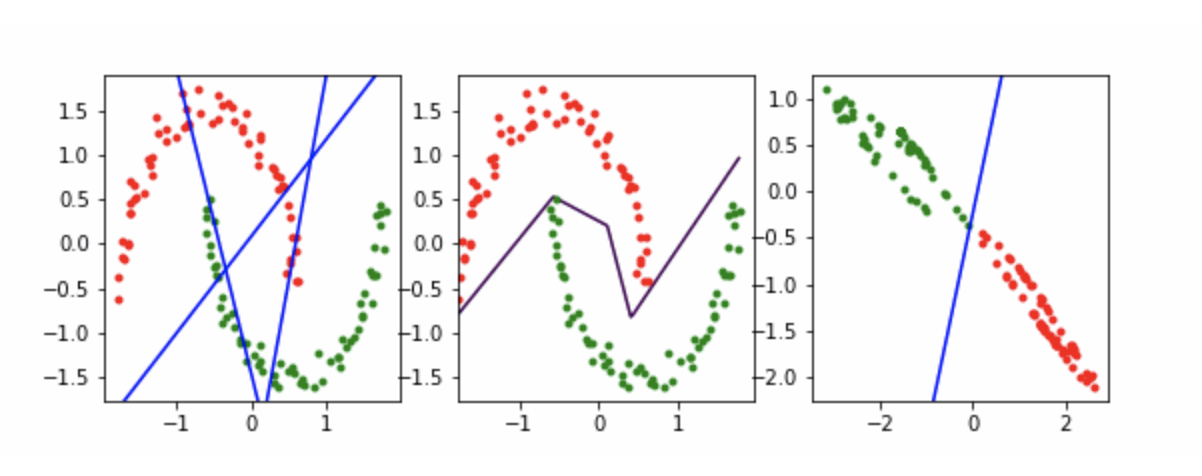


https://medium.com/make-computer-science-fun-again/learning-from-small-neural-networks-6bc5ffc2f3d3

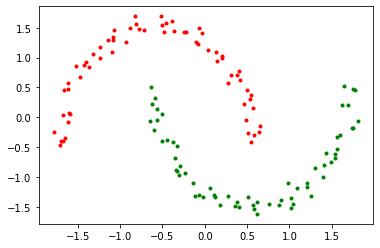

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

N = 128
X, Y = make_moons(N, noise=0.05)
X = scale(X)

def plot2(x, y, Ws=[], bs=[], ax=None, colors='rgb'):
  """Draw a 2D plot of data, with lines on the plot.

  Arguments:
    x: The 2D data. Should be an Nx2 array.
    y: Labels for the data (0 or 1).
    Ws, bs: Weights and biases of neurons, used for drawing lines.
    ax: The matplotlib axes to draw on. Useful for drawing animation frames. If None, it will create a new figure.
    colors: Three colors for 0-labeled data, 1-labeled data, lines.
  """
  show = ax is None

  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
  artists = []
    
  for i in (0, 1):
    xi = x[y == i]
    artists.append(ax.plot(xi[:, 0], xi[:, 1], colors[i] + '.')[0])
  
  ylim = ax.get_ylim()

  for i, W in enumerate(Ws):
    b = bs[i]
    xmin, xmax = x[:, 0].min(), x[:, 0].max()
    m = -W[0] / W[1]
    b /= -W[1]
    ymin = m * xmin + b
    ymax = m * xmax + b
    artists.append(ax.plot([xmin, xmax], [ymin, ymax], colors[-1] + '-')[0])

  ax.set_ylim(*ylim)

  if show:
    plt.show()
  
  return artists

plot2(X, Y)

In [ ]:
from keras.layers import Dense
from keras.models import Sequential

batch_size = N // 8

model = Sequential()
# 1 neuron. Basically fit a line.
model.add(Dense(1, activation='sigmoid', input_dim=2))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.fit(X, Y, epochs=1000, batch_size=batch_size, verbose=False)
model.evaluate(X, Y)

Using TensorFlow backend.


128/128 [==============================] - 0s 161us/step


[0.25240835547447205, 0.8828125]

[[ 1.0458318]
 [-2.7910497]]
[-0.03406096]


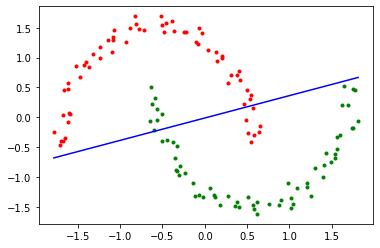

In [ ]:
# Show line weights and plot line with data.
W, b = model.layers[-1].get_weights()
print(W)
print(b)
plot2(X, Y, [W], [b])

In [ ]:
# Make a very small network. Note, because this is a tiny NN, you may need to run this many times to get decent results.
model = Sequential()
model.add(Dense(3, activation='relu', input_dim=2))
# Add this layer without a nonlinearity so we can use it to show the transformed input space.
# This shows how the input space looks when transformed to be (hopefully) linearly separable.
model.add(Dense(2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.fit(X, Y, epochs=1000, batch_size=batch_size, verbose=False)
model.evaluate(X, Y)

128/128 [==============================] - 0s 173us/step


[0.03950727917253971, 1.0]

[[ 0.1304893]
 [-3.058247 ]]
[0.54520285]


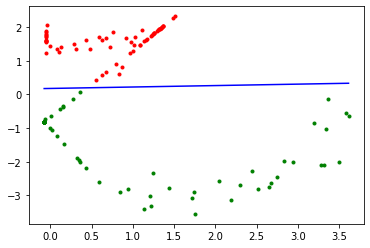

In [ ]:
from keras.backend import function

for ly in model.layers:
  W, b = ly.get_weights()

# Transform the input space to the output space (which is hopefully linearly separable).
transform = function([model.input], [model.layers[-2].output])

Xt = transform([X])[0]
print(W)
print(b)
plot2(Xt, Y, [W], [b])

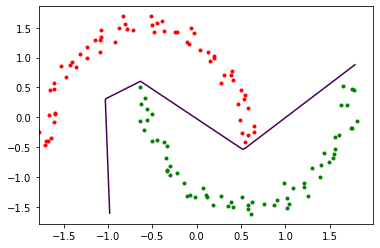

In [ ]:
import numpy as np

def plotc(x, y, f, ax=None):
  """Plot the contour of the decision boundary (where the final hidden layer output is zero). This essentially maps
  the line that separates the data in the transformed final layer back into the input space.
  
  Arguments:
    x: The 2D data.
    y: Labels.
    f: A Tensorflow function mapping the NN input to output.
    ax: Matplotlib axes if drawing in an animation. If None, plot a new figure.
  """
  d = 0.025
  xmin = X.min(axis=0)
  xmax = X.max(axis=0)
  x1s, x2s = np.meshgrid(np.arange(xmin[0], xmax[0], d), np.arange(xmin[1], xmax[1], d))
  zs = f(np.hstack((x1s.reshape((-1, 1)), x2s.reshape((-1, 1))))).reshape(x1s.shape)
  
  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

  artists = plot2(x, y, ax=ax)
  cont = ax.contour(x1s, x2s, zs, levels=[0.5])
  artists.extend(cont.collections)
  return artists

ft = function([model.input], [model.output])

def f(x):
  return ft([x])[0]

plotc(X, Y, f)

[[-1.4205332   1.8373061   1.0612814 ]
 [-0.03674371 -0.420486    1.0724696 ]]
[-0.87911236 -1.1916149   0.7662307 ]


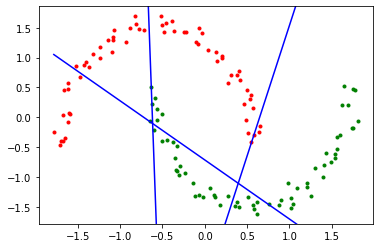

In [ ]:
# Show the weights of the hidden layer and plot them as lines on the input space.
W, b = model.layers[0].get_weights()
print(W)
print(b)
plot2(X, Y, Ws=list(W.T), bs=list(b.T))

In [ ]:
!apt install imagemagick

128/128 [==============================] - 0s 199us/step
[0.26296498626470566, 0.890625]


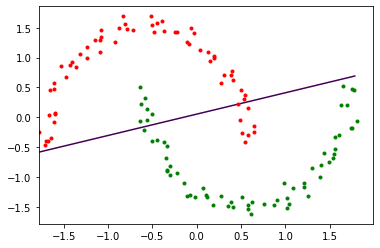

In [ ]:
# Do the same thing as above, but capture the animation as it trains.
from keras.callbacks import LambdaCallback
from matplotlib.animation import ArtistAnimation
from matplotlib import rc

model = Sequential()
model.add(Dense(3, activation='relu', input_dim=2))
model.add(Dense(2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

transform = function([model.input], [model.layers[-2].output])

ft = function([model.input], [model.output])

def f(x):
  return ft([x])[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
frames = []

# def plot(*_):
#   Xt = transform([X])[0]
#   W, b = model.layers[-1].get_weights()
#   frames.append(plot2(Xt, Y, [W], [b], ax=ax))

def plot(*_):
  frames.append(plotc(X, Y, f, ax=ax))

plot_cb = LambdaCallback(on_epoch_end=plot)

model.fit(X, Y, epochs=500, batch_size=batch_size, verbose=False, callbacks=[plot_cb])
print(model.evaluate(X, Y))

rc('animation', html='html5')
ani = ArtistAnimation(fig, frames, interval=50, blit=True, repeat=False)
ani.save('moon_split.gif', writer='imagemagick')

ani

128/128 [==============================] - 0s 194us/step
[0.22409087046980858, 0.8984375]



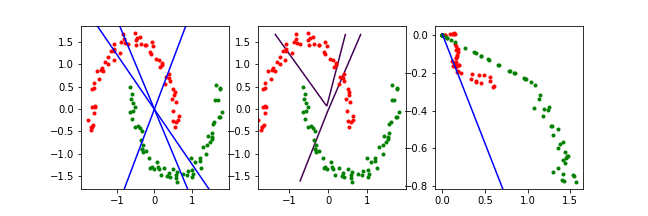

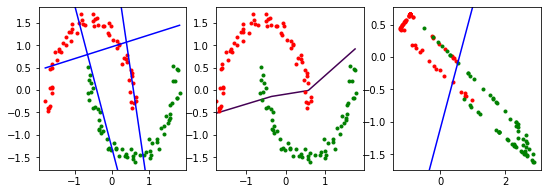

In [ ]:
# Another way to do the animation.
from base64 import b64encode
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

model = Sequential()
model.add(Dense(3, activation='relu', input_dim=2))
model.add(Dense(2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

transform = function([model.input], [model.layers[-2].output])

ft = function([model.input], [model.output])

def f(x):
  return ft([x])[0]

fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

def draw(*_):
  ax1.clear()
  W, b = model.layers[0].get_weights()
  plot2(X, Y, Ws=list(W.T), bs=list(b.T), ax=ax1)
  
  ax2.clear()
  plotc(X, Y, f, ax=ax2)

  ax3.clear()
  Xt = transform([X])[0]
  W, b = model.layers[-1].get_weights()
  plot2(Xt, Y, [W], [b], ax=ax3)

def update_and_draw(*_):
  model.fit(X, Y, epochs=1, batch_size=batch_size, verbose=False)
  draw()

rc('animation', html='html5')
ani = FuncAnimation(fig, update_and_draw, frames=500, init_func=draw, interval=50, blit=False, repeat=True)
ani.save('moon_split.gif', writer='imagemagick')

print(model.evaluate(X, Y))

with open("moon_split.gif", "rb") as fp:
  data = b64encode(fp.read()).decode("utf-8")

HTML(f'<img src="data:image/png;base64,{data}" />')

128/128 [==============================] - 0s 186us/step
Loss = 0.19741785153746605, Accuracy = 0.90625
128/128 [==============================] - 0s 190us/step
Loss = 0.2505495809018612, Accuracy = 0.890625
128/128 [==============================] - 0s 177us/step
Loss = 0.014897295972332358, Accuracy = 1.0
128/128 [==============================] - 0s 183us/step
Loss = 0.015412763925269246, Accuracy = 1.0
128/128 [==============================] - 0s 190us/step
Loss = 0.22963318601250648, Accuracy = 0.890625
128/128 [==============================] - 0s 184us/step
Loss = 0.021359768696129322, Accuracy = 1.0
128/128 [==============================] - 0s 195us/step
Loss = 0.011566989356651902, Accuracy = 1.0
128/128 [==============================] - 0s 180us/step
Loss = 0.23915788531303406, Accuracy = 0.890625
128/128 [==============================] - 0s 180us/step
Loss = 0.16399948298931122, Accuracy = 0.9296875
128/128 [==============================] - 0s 182us/step
Loss = 0.211385

(array([4., 1., 0., 1., 0., 0., 0., 0., 0., 4.]),
 array([0.890625 , 0.9015625, 0.9125   , 0.9234375, 0.934375 , 0.9453125,
        0.95625  , 0.9671875, 0.978125 , 0.9890625, 1.       ]),
 <a list of 10 Patch objects>)

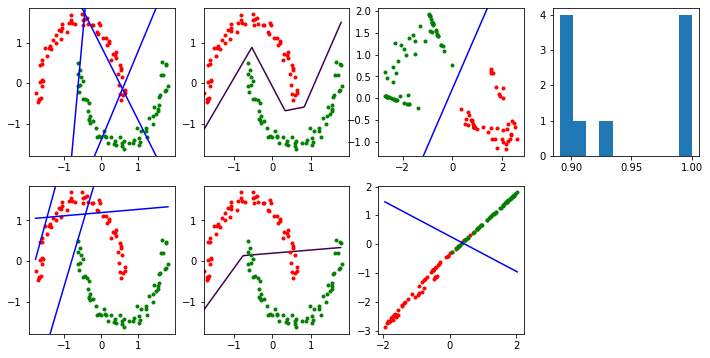

In [ ]:
# Retrains many times to see the impact of random initialization
from keras.layers import Dense
from keras.models import Sequential

n_trials = 10
accs = []
best_model = None
worst_model = None

for _ in range(n_trials):
  model = Sequential()
  model.add(Dense(3, activation='relu', input_dim=2))
  model.add(Dense(2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='SGD',
                metrics=['accuracy'])

  model.fit(X, Y, epochs=1000, batch_size=batch_size, verbose=False)
  loss, acc = model.evaluate(X, Y)
  accs.append(acc)
  print(f"Loss = {loss}, Accuracy = {acc}")
  if acc == max(accs):
    best_model = model
  if acc == min(accs):
    worst_model = model

# Best
ft = function([best_model.input], [best_model.output])

def f(x):
  return ft([x])[0]

transform = function([best_model.input], [best_model.layers[-2].output])

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)

W, b = best_model.layers[0].get_weights()
plot2(X, Y, Ws=list(W.T), bs=list(b.T), ax=ax1)

plotc(X, Y, f, ax=ax2)

Xt = transform([X])[0]
W, b = best_model.layers[-1].get_weights()
plot2(Xt, Y, [W], [b], ax=ax3)

# Worst
ft = function([worst_model.input], [worst_model.output])

def f(x):
  return ft([x])[0]

transform = function([worst_model.input], [worst_model.layers[-2].output])

ax5 = fig.add_subplot(2, 4, 5)
ax6 = fig.add_subplot(2, 4, 6)
ax7 = fig.add_subplot(2, 4, 7)

W, b = worst_model.layers[0].get_weights()
plot2(X, Y, Ws=list(W.T), bs=list(b.T), ax=ax5)

plotc(X, Y, f, ax=ax6)

Xt = transform([X])[0]
W, b = worst_model.layers[-1].get_weights()
plot2(Xt, Y, [W], [b], ax=ax7)

ax4.hist(accs)